# <center>Word2Vec</center>
<center> Shan-Hung Wu & DataLab </center>
<center> Fall 2020 </center>

## Neural Language Model

Neural probabilistic language models are traditionally trained using the maximum likelihood principle to estimate the probability distribution of the next word $w_t \in Vocabulary$ ($t$ for "targets") given the previous words $h$ ($h$ for "history") in terms of a softmax function. In other words, we build a multi-label classification model whose classes include all the words in the vocabulary.

Scenario of traditional laguage model task:

<img src="assets/language_model.jpg" width="300">

Note that the network outputs the entire **distribution for all words in the vocabulary set**, not only the most likely word (the read "here" in the image).

The classic neural language model (Bengio et al., 2001; 2003) contains three layers: 
<img src="assets/bengio-language-model.png" width="350">
- **Embedding Layer**: a layer that generates word embeddings by multiplying an index vector with a word embedding matrix.The layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings);
- **Intermediate Layer(s)**: one or more layers that concatenate inputs and produce an intermediate representation, e.g. a fully-connected layer that applies a non-linearity to the concatenation of word embeddings of n previous words;
- **Softmax Layer**: the final layer that produces a probability distribution over words in $V$.


The probability distribution of the next words $w_t \in Vocab$

$$P(w_t|h)=\textrm{softmax}(\textrm{score}(w_t,h))=\frac{\textrm{exp}\{\textrm{score}(w_t,h)\}}{\sum_{\textrm{Word w in Vocab}}\textrm{exp}\{\textrm{score}(w,h)\}}$$

where $\textrm{score}(w_t,h)$ computes the compatibility of words $w_t$ with the context $h$. We train this model by maximizing its log-likelihood on the training set, i.e. by maximizing
$$
\log(P(w_t|h))=\textrm{score}(w_t,h)-\log\Bigg(\sum_{\textrm{Word w in Vocab}}\textrm{exp}\{\textrm{score}(w,h)\}\Bigg)
$$

This yields a properly normalized probabilistic model for language modeling. However, this is computationally expensive since the cost of computing "softmax" is proportional to the number of words in vocabulary which is typically on the order of hundreds of thousands or millions. We will need the softmax operation to normalize probability distribution **at every training step**.
<img src="assets/softmax-nplm.png" width="350">

# Word2Vec
Reference: 
- [Vector Representations of Words](https://www.tensorflow.org/tutorials/representation/word2vec)

Neural language model is only able to look at the past words for its predictions, as it is evaluated on its ability to predict each next word in the corpus. However, a model that just aims to generate accurate word embeddings does not suffer from this restriction. Word2Vec is a computationally-efficient model that learns to embed words into vectors accurately. The goal is to map words that have similar meanings close to each other.

## Why represent words as vectors?
When we dealing with words, a straightforward way would be treating each word as discrete symbols. For instance, `cat` as `2` and `dog` as `1`. However, these symbols carry no information about the relationships, making it impossible for us to infer the relationship between cats and dogs (both are four-legged animals and pets) based on the `1` and `2` alone. Hence, to successfully learn the relationship between them, we need a better representation.  
**Vector space models (VSMs)** which represent words as vectors can help overcome these obstacles. This is based on a key observation that **semantically similar words are often interchangeable**. For example, the words `cat` and `dog` may both appear in a context "\_\_\_ is my favorite pet." When feeding `cat` and `dog` into the embedding networks, these two words will be likely to share the same/similar hidden representations. 

## Skip-Gram and CBOW
There are two variants of word2vec methods: **Skip-Gram** and **CBOW (Continuous Bag-Of-Words)**. Algorithmically, these models are similar. CBOW predicts the target words using its neighborhood(context) whereas Skip-Gram does the inverse, which predicts context words from the target words. For example, given the sentence `the quick brown fox jumped over the lazy dog`. Defining the context words as the word to the left and right of the target word, CBOW will be trained on the dataset: 

`([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox)...`  

where CBOW tries to predict the target word `quick` from the context words in brackets `[the, brown]`, and predict `brown` from `[quick, fox]` and so on.
However, with Skip-Gram, the dataset becomes  

`(quick, the), (quick, brown), (brown, quick), (brown, fox), ...`  

where Skip-Gram predicts the context word `the`, `brown` with the target word `quick`. Statistically, CBOW smoothes over a lot of the distributional information (by treating an entire context as one example). For the most part, this turns out to be a useful thing for smaller datasets. On the other hand, Skip-Gram treats each context-target pair as a new observation and is shown to be able to capture the semantics better when we have a large dataset.

| <img src="assets/Cbow.png" width="350"/> | <img src="assets/Skip-gram.png" width="350"/> |
|:----------------------------------------:|:---------------------------------------------:|
|            <center>CBOW</center>         |          <center>Skip-gram</center>           |

Note that the tasks described above are only used to train the embedding network, we don’t use the whole neural network. What we want is the weights of the hidden layer, the "embedding matrix".  

For the rest of the tutorial, we will focus on the **Skip-Gram** model.

### A Solution for the Softmax: Approximation with Noise Contrastive Estimation

Let's recap the objective which is to maximize log-likelihood:
$$
 \underset{\theta}{\textrm{argmax}} \ \textrm{score}(w_t,h)-\log\Bigg[\sum_{\textrm{w} \in \textrm{Vocab}}\textrm{exp}\ (\textrm{score}(w,h))\Bigg]
$$
Mathematically, the gradient of the objective function is

$$
\nabla_{\theta} \ \textrm{score}(w_t,h) - \mathop{\mathbb{E}}_{\tilde{w} \sim P_{noise}}[\nabla_{\theta} \ \textrm{score}(\tilde{w},h)]
$$
The gradient essentially has two parts: a positive reinforcement for the target word $w_t$ (the first term in the above equation) and a negative reinforcement for all other words $\tilde{w}$, which is weighted by their probability (the second term).
In practice, since we don't want to sum over the probabilities for all words in the vocabulary, we approximate the expectation term of the negative reinforcement by drawing noise words and pairing with the target word $w_t$ to form the negative samples. Then, the expectation of these negative smaples can be an approximation of the real expectation.

With the **skip-gram** word2vec, we do not need a full probabilistic model. Since we have positive samples from the corpus and negative samples obtained from random sampling, the models instead can be trained with logistic regression objective to discriminate the target words $w_t$ from $k$ noise words $\tilde{w}$ (random samples, or unigram samples), given the same context. It designates all correct words $w_t$ given their context $c_i$ in the context window as true (y=1) and all noise samples $\tilde{w}$ as false (y=0). We illustrate this below for a CBOW model. For skip-gram, simply switch words "mat" and "the cat sit on the" in the box.
<img src="assets/nce-nplm.png" width="350">

The objective of skip-gram with noise contrastive estimation(NCE) is to maximize:

$$
\log Q_\theta(D=1|w_t,h)+k\mathop{\mathbb{E}}_{\tilde{w} \sim P_{noise}}[\log Q_\theta(D=0|\tilde{w},h)]
$$

where $Q$ is the simplfied distribution (often, unigram distribution), $Q_\theta(D=1|w_t,h)$ is the probability of that word $w_t$ existing in the context window $h$ appears in the dataset $D$ (probability of the positive pair $(w_t, h)$ appears in the corpus). And $Q_\theta(D=0|\tilde{w},h)$ is the probability of that word $\tilde{w}$ existing in the context window $h$ don't exist in the dataset $D$ (probability of the negative pair $(\tilde{w}, h)$ is not in the corpus). TensorFlow supports high level API of NCE loss, we will demonstrate the skip-gram algorithm with the API in the following sections.

For students intersted in the deduction of the formula, here are the [reference](https://ruder.io/word-embeddings-softmax/index.html#noisecontrastiveestimation), [reference2](https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html),and [detail implementation](https://aegis4048.github.io/optimize_computational_efficiency_of_skip-gram_with_negative_sampling).

## Skip-gram with NCE Loss in TensorFlow
### The Dataset
The dataset we use is **text8**, which is the first 100 MB of cleaned text of the English Wikipedia dump on Mar. 3, 2006. While 100MB is not enough to train really good embeddings, we can still see some interesting relations. Splitting the text by blank space, we can find that there are 17,005,207 tokens in total.

### Preparing training data
To generate batches for training, several functions defined below are used. First, we read the data into the memory and build the vocabulary using a number of most commonly seen words. Meanwhile, we build two dictionaries, a dictionary that translates words to indices and another which does the reverse. Then, for every word in the text selected as the center word, pair them with one of the context words. Finally, a python generator which generates a batch of pairs of center-target pairs.

In [1]:
import tensorflow as tf
import numpy as np
import random

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPUs


In [3]:
import os
import urllib

# Download the data.
DOWNLOAD_URL = 'http://mattmahoney.net/dc/'
DATA_FOLDER = "data"
FILE_NAME = "text8.zip"
EXPECTED_BYTES = 31344016

def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass
    
def download(file_name, expected_bytes):
    """ Download the dataset text8 if it's not already downloaded """
    local_file_path = os.path.join(DATA_FOLDER, file_name)
    if os.path.exists(local_file_path):
        print("Dataset ready")
        return local_file_path
    file_name, _ = urllib.request.urlretrieve(os.path.join(DOWNLOAD_URL, file_name), local_file_path)
    file_stat = os.stat(local_file_path)
    if file_stat.st_size == expected_bytes:
        print('Successfully downloaded the file', file_name)
    else:
        raise Exception(
              'File ' + file_name +
              ' might be corrupted. You should try downloading it with a browser.')
    return local_file_path    
    
make_dir(DATA_FOLDER)
file_path = download(FILE_NAME, EXPECTED_BYTES)

Dataset ready


In [4]:
import zipfile

# Read the data into a list of strings.
def read_data(file_path):
    """ Read data into a list of tokens """
    with zipfile.ZipFile(file_path) as f:
        # tf.compat.as_str() converts the input into string
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(file_path)
print('Data size', len(vocabulary))

Data size 17005207


In [5]:
vocabulary[:5]

['anarchism', 'originated', 'as', 'a', 'term']

#### Build the dictionary

In CBOW and skip-gram, negative reinforcement can be approximated with non-context word pairs. 

In [6]:
import collections
# Build the dictionary and replace rare words with UNK token.
def build_dataset(words, n_words):
    """ Create two dictionaries and count of occuring words
        - word_to_id: map of words to their codes
        - id_to_word: maps codes to words (inverse word_to_id)
        - count: map of words to count of occurrences
    """
    # map unknown words to -1
    count = [['UNK', -1]]
    # count of occurences for words in vocabulary
    count.extend(collections.Counter(words).most_common(n_words - 1)) 
    word_to_id = dict() # (word, id)
    # record word id
    for word, _ in count:
        word_to_id[word] = len(word_to_id)
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys())) # (id, word)
    return word_to_id, id_to_word, count

def convert_words_to_id(words, dictionary, count):
    """ Replace each word in the dataset with its index in the dictionary """
    data_w2id = []
    unk_count = 0
    for word in words:
        # return 0 if word is not in dictionary
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data_w2id.append(index)
    count[0][1] = unk_count
    return data_w2id, count

In [7]:
"""Filling 4 global variables:
# data_w2id - list of codes (integers from 0 to vocabulary_size-1).
              This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# word_to_id - map of words(strings) to their codes(integers)
# id_to_word - maps codes(integers) to words(strings)
"""

vocabulary_size = 50000
word_to_id, id_to_word, count = build_dataset(vocabulary, vocabulary_size)
data_w2id, count = convert_words_to_id(vocabulary, word_to_id, count)
del vocabulary  # reduce memory.

In [8]:
print('Most common words (+UNK)', count[:5])
print('Sample data: {}'.format(data_w2id[:10]))
print([id_to_word[i] for i in data_w2id[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data: [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [9]:
# utility function
def generate_sample(center_words, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for idx, center in enumerate(center_words):
        context = random.randint(1, context_window_size)
        # get a random target before the center word
        for target in center_words[max(0, idx - context) : idx]:
            yield center, target
        # get a random target after the center word
        for target in center_words[idx + 1 : idx + context + 1]:
            yield center, target

def batch_generator(data, skip_window, batch_size):
    """ Group a numeric stream into batches and yield them as Numpy arrays. """
    single_gen = generate_sample(data, skip_window)
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for idx in range(batch_size):
            center_batch[idx], target_batch[idx] = next(single_gen)
        yield center_batch, target_batch

### Skip-gram word2vec model
Reference: 
- [Writing custom layers and models with Keras](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

In [10]:
## some training settings
training_steps = 100000
skip_step = 2000

## some hyperparameters
batch_size = 512
embed_size = 512
num_sampled = 256
learning_rate = 1.0

- Layer Subclassing

In [11]:
from tensorflow.keras.layers import Layer

# embedding matrix - hidden layer
class embedding_lookup(Layer):
    def __init__(self):
        super(embedding_lookup, self).__init__()
        embedding_init = tf.keras.initializers.GlorotUniform()
        self.embedding_matrix = self.add_weight(name="embedding_matrix",
                                                trainable=True,
                                                shape=[vocabulary_size, embed_size],
                                                initializer=embedding_init)

    def call(self, inputs):
        center_words = inputs
        embedding = tf.nn.embedding_lookup(self.embedding_matrix,
                                           center_words, 
                                           name='embedding')
        return embedding

# context matrix - prediction layer
class nce_loss(Layer):
    def __init__(self):
        super(nce_loss, self).__init__()
        nce_w_init = tf.keras.initializers.TruncatedNormal(stddev=1.0/(embed_size ** 0.5))
        self.nce_weight = self.add_weight(name='nce_weight',
                                          trainable=True,
                                          shape=[vocabulary_size, embed_size],
                                          initializer=nce_w_init)
        self.nce_bias = self.add_weight(name='nce_bias',
                                        trainable=True,
                                        shape=[vocabulary_size],
                                        initializer=tf.keras.initializers.Zeros)

    def call(self, inputs):
        embedding, target_words = inputs[0], inputs[1]
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=self.nce_weight, 
                                             biases=self.nce_bias, 
                                             labels=target_words, 
                                             inputs=embedding, 
                                             num_sampled=num_sampled, 
                                             num_classes=vocabulary_size),
                                             name='loss')
        return loss

- Functional API

In [12]:
from tensorflow.keras import Model, Input

center_words = Input(shape=(), name='center_words', dtype='int32')
target_words = Input(shape=(1), name='target_words', dtype='int32')

embedding = embedding_lookup()(center_words)
loss = nce_loss()((embedding, target_words))

word2vec = Model(name='word2vec',
                 inputs=[center_words, target_words],
                 outputs=[loss])

In [13]:
word2vec.summary()

Model: "word2vec"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
center_words (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
embedding_lookup (embedding_loo (None, 512)          25600000    center_words[0][0]               
__________________________________________________________________________________________________
target_words (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
nce_loss (nce_loss)             ()                   25650000    embedding_lookup[0][0]           
                                                                 target_words[0][0]        

In [14]:
## geneartor for `tf.data.Dataset`
def gen():
    """ Return a python generator that generates batches. """
    yield from batch_generator(data_w2id, 2, batch_size)

dataset = tf.data.Dataset.from_generator(gen, 
                                         (tf.int32, tf.int32),
                                         (tf.TensorShape([batch_size]), tf.TensorShape([batch_size, 1])))\
                         .repeat()

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1,nesterov=True)

In [16]:
@tf.function
def train_step(center_words, target_words):
    with tf.GradientTape() as tape:
        loss = word2vec([center_words, target_words])
    gradients = tape.gradient(loss, word2vec.trainable_variables)
    optimizer.apply_gradients(zip(gradients, word2vec.trainable_variables))

    train_loss(loss)

In [17]:
x = []
y = []
for step, (center_words, target_words) in enumerate(dataset):
    if step == training_steps:
        break
    train_step(center_words, target_words)

    if ((step+1) % skip_step) == 0:
        template = 'Step {:0}, Loss: {:.2f}'
        x.append(step+1)
        y.append(train_loss.result())
        print (template.format(step+1, train_loss.result()))
        train_loss.reset_states()

Step 2000, Loss: 174.60
Step 4000, Loss: 31.70
Step 6000, Loss: 15.47
Step 8000, Loss: 10.66
Step 10000, Loss: 9.68
Step 12000, Loss: 8.71
Step 14000, Loss: 8.10
Step 16000, Loss: 7.44
Step 18000, Loss: 7.13
Step 20000, Loss: 6.97
Step 22000, Loss: 6.94
Step 24000, Loss: 6.73
Step 26000, Loss: 6.59
Step 28000, Loss: 6.42
Step 30000, Loss: 6.45
Step 32000, Loss: 6.39
Step 34000, Loss: 6.26
Step 36000, Loss: 6.28
Step 38000, Loss: 6.15
Step 40000, Loss: 6.14
Step 42000, Loss: 6.10
Step 44000, Loss: 5.95
Step 46000, Loss: 5.93
Step 48000, Loss: 5.98
Step 50000, Loss: 5.88
Step 52000, Loss: 5.88
Step 54000, Loss: 5.96
Step 56000, Loss: 5.88
Step 58000, Loss: 5.84
Step 60000, Loss: 5.91
Step 62000, Loss: 5.82
Step 64000, Loss: 5.81
Step 66000, Loss: 5.88
Step 68000, Loss: 5.80
Step 70000, Loss: 5.74
Step 72000, Loss: 5.89
Step 74000, Loss: 5.77
Step 76000, Loss: 5.45
Step 78000, Loss: 5.60
Step 80000, Loss: 5.70
Step 82000, Loss: 5.83
Step 84000, Loss: 5.74
Step 86000, Loss: 5.80
Step 88000

UnknownError: RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "<ipython-input-9-fbeab29bf9f1>", line 20, in batch_generator
    center_batch[idx], target_batch[idx] = next(single_gen)

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/kjliu/anaconda3/envs/101/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 244, in __call__
    ret = func(*args)

  File "/home/kjliu/anaconda3/envs/101/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "/home/kjliu/anaconda3/envs/101/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 827, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "<ipython-input-14-cf421e077f48>", line 4, in gen
    yield from batch_generator(data_w2id, 2, batch_size)

RuntimeError: generator raised StopIteration


	 [[{{node PyFunc}}]]

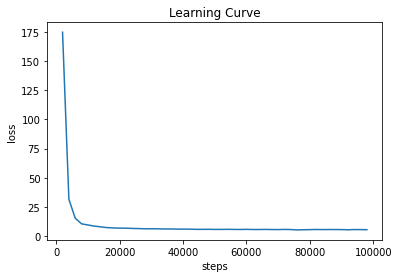

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.plot(x, y)
plt.show()

### Visualizing the learned embeddings
After training we can visualize the learned embeddings using [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).  
We can see that similar words are near to each other.

In [19]:
# get embedding matrxi from model weights. > word2vec.weights[0]
embedding_matrix = word2vec.weights[0]

In [20]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18), dpi=150)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

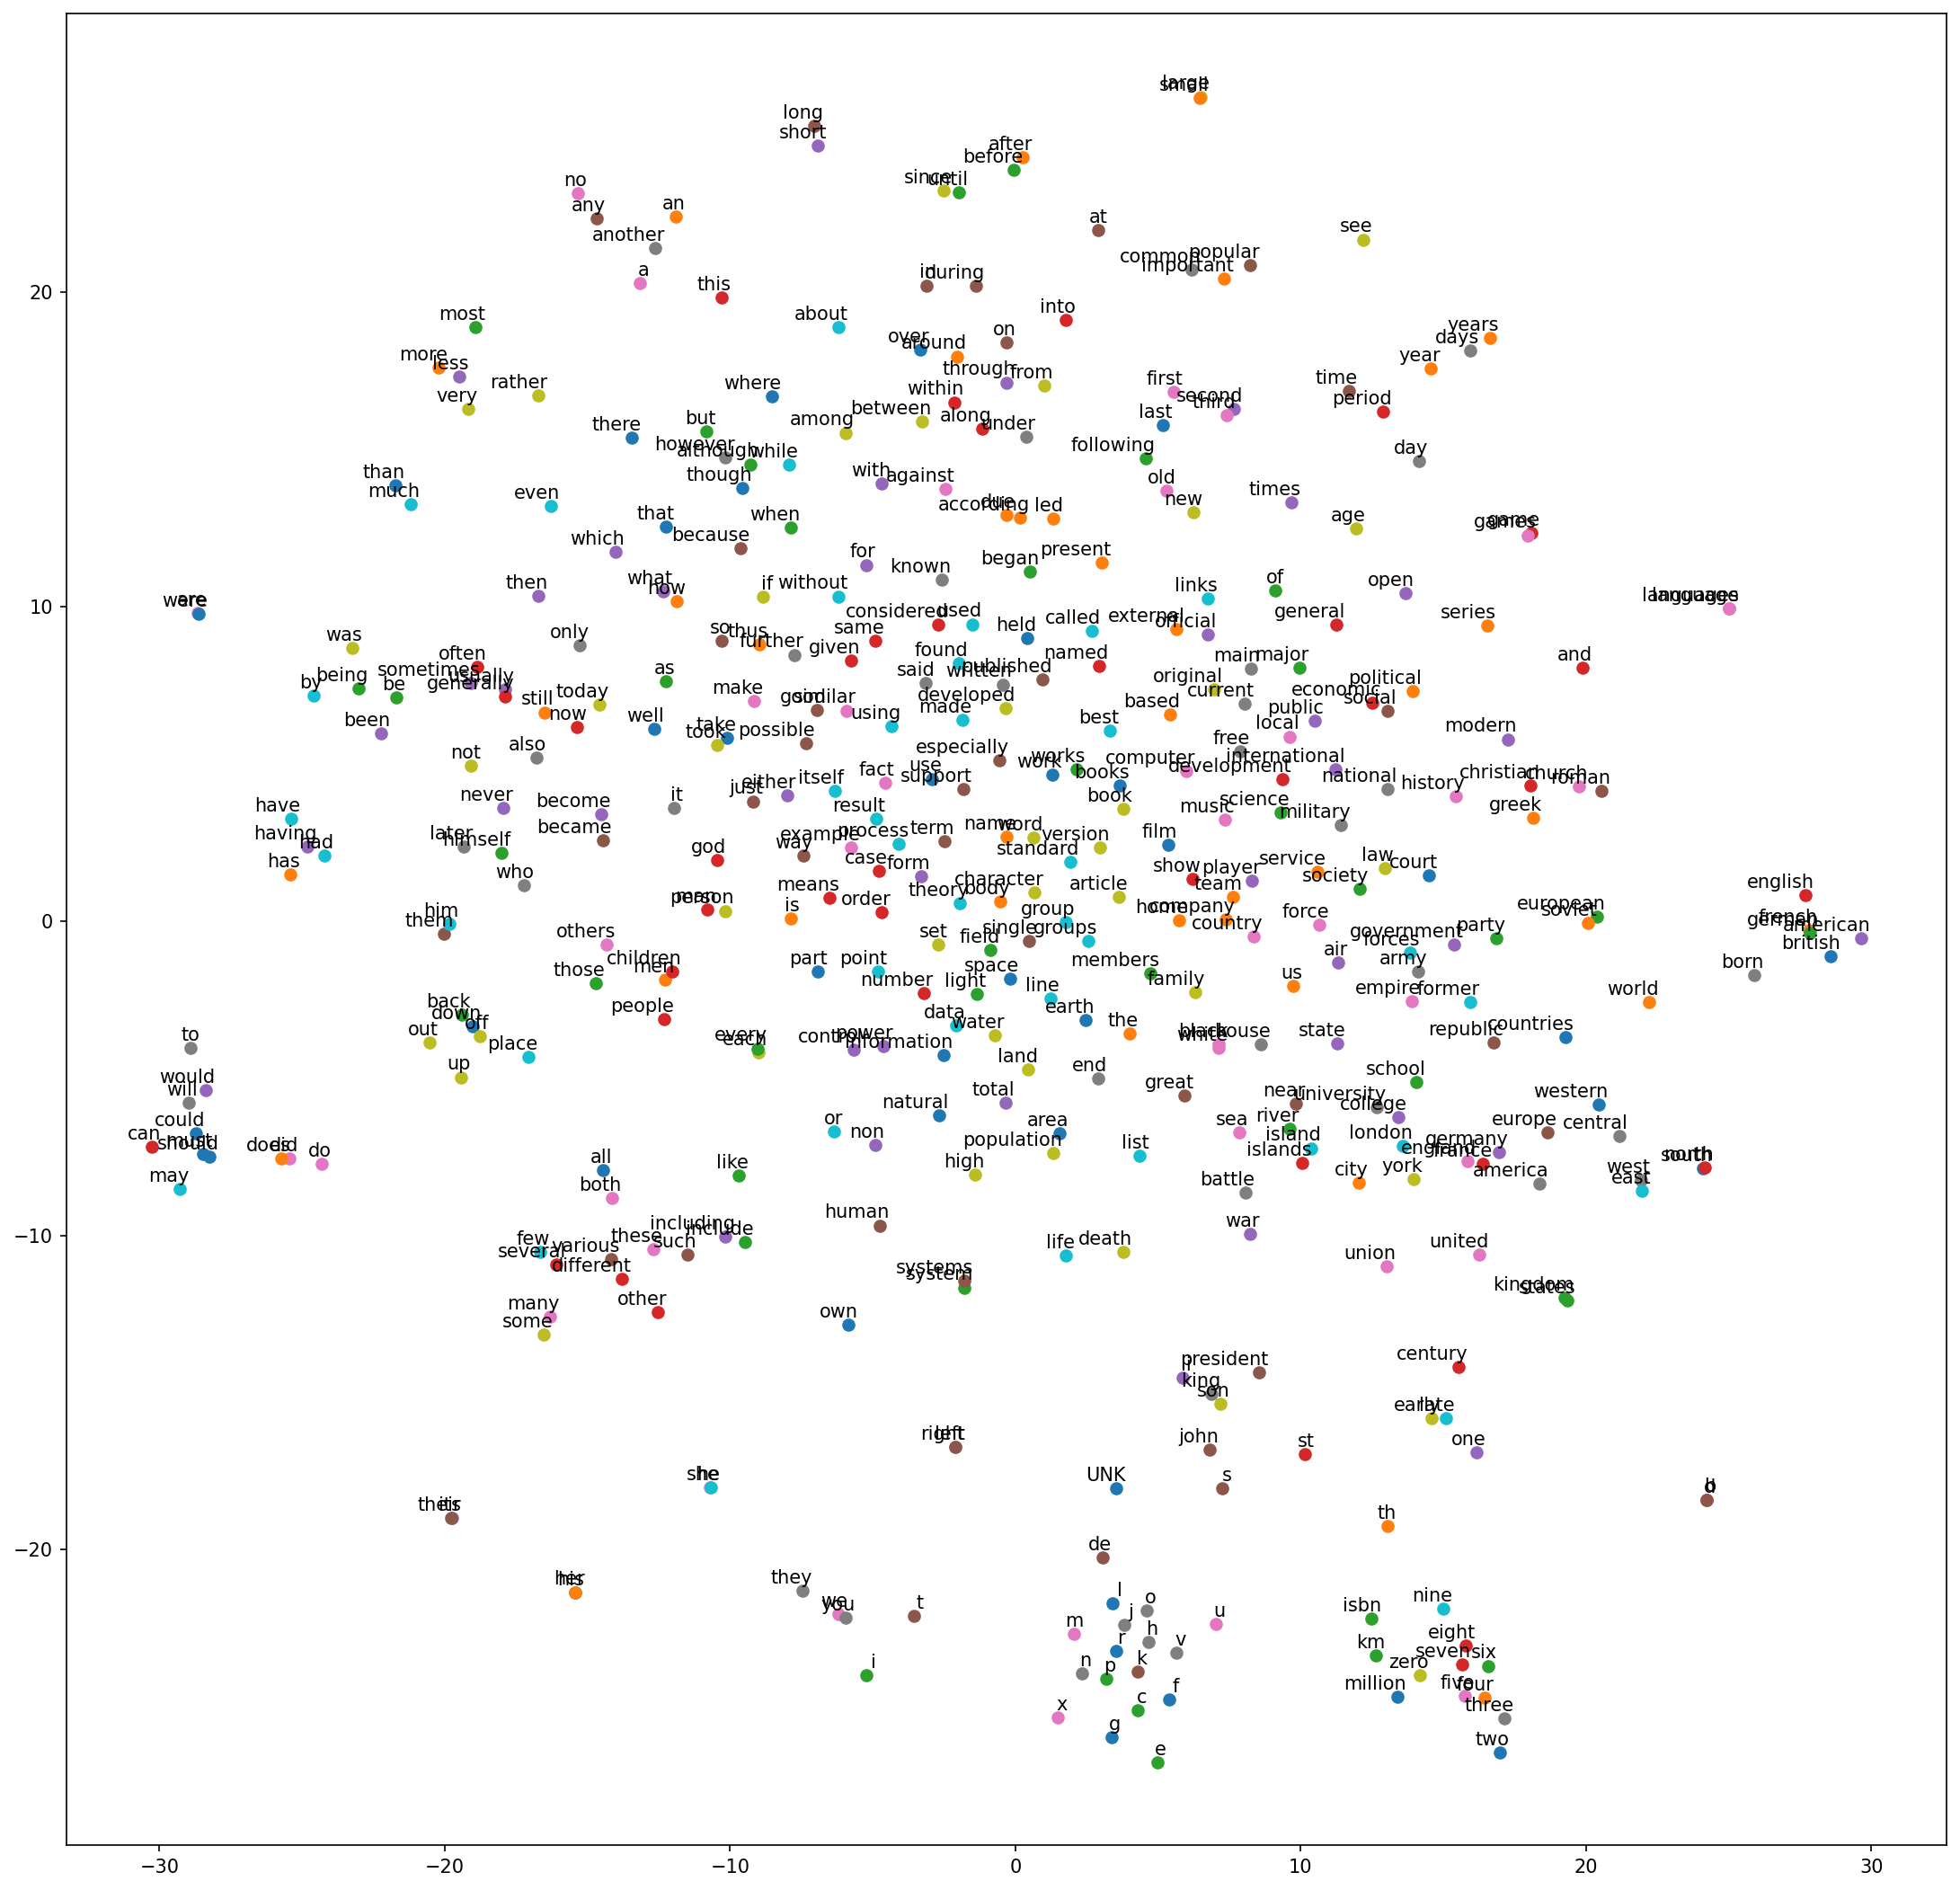

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 400
final_embeddings = embedding_matrix
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id_to_word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

### Cosine Similarity
[cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is a simple metrics for evaluating the similarity between two vectors.
$$
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\textrm{similarity} = \cos(\theta) = \frac{\textrm{A} \cdot \textrm{B}}{\norm{\textrm{A}} \cdot \norm{\textrm{B}}}
$$

In [22]:
import numpy.linalg as LA

In [23]:
# handy method for calculating the similarity between 2 word
def cos_sim(word1, word2):
    id1 = word_to_id[word1]
    id2 = word_to_id[word2]
    
    vec1 = embedding_matrix[id1].numpy()
    vec2 = embedding_matrix[id2].numpy()

    return np.dot(vec1, vec2) / (LA.norm(vec1) * LA.norm(vec2))

In [28]:
cos_sim('cat', 'dog'), cos_sim('man', 'woman')

(0.9792077, 0.9134161)

In [29]:
def top_k_nearest(word, k):
    vec = embedding_matrix[word_to_id[word]]
    
    # calaulate cosine similarity  of `vec` and all other vocabularies
    dot = np.dot(embedding_matrix.numpy(), vec)
    embedding_norm = LA.norm(embedding_matrix.numpy(), axis=-1)
    vec_norm = LA.norm(vec)
    norm_product = embedding_norm * vec_norm
    cos_sim = dot / norm_product
    
    # print out top k nearest words
    indices = np.argsort(cos_sim)[::-1][:k]
    print('---top {} nearest words of {}---'.format(k, word))
    for idx in indices:
        print(id_to_word[idx])
    print('\n')

In [30]:
top_k_nearest('england', 5)
top_k_nearest('rock', 5)

---top 5 nearest words of england---
england
spain
scotland
italy
russia


---top 5 nearest words of rock---
rock
jazz
pop
folk
punk




# Assignment

1. Devise Word2Vec model by subclassing keras.Model

In [39]:
from tensorflow.keras import Model

class Word2Vec(Model):
    def __init__(self):
        '''To-Do: Define model variables'''

    def call(self, center_words, target_words):
        '''To-Do: Define data flow and return loss'''

2. Train your word2vec model and plot your learning curve
3. Visualize your embedding matrix by t-SNE
4. Show top-5 nearest neighbors of two words.(pick by yourself)
5. Submit your **ipynb** to iLMS with the format Lab11_{student_id}.ipynb.

- Deadline: 2020-11-5(Thur) 23:59